# 1. Load packages

The link to get [ImageAnalysis3](https://github.com/zhengpuas47/ImageAnalysis3) 

or the Zhuang lab archived [source_tools](https://github.com/ZhuangLab/Chromatin_Analysis_2020_cell/tree/master/sequential_tracing/source)

In [1]:
%run "C:\Users\shiwei\Documents\ImageAnalysis3\required_files\Startup_py3.py"
sys.path.append(r"C:\Users\shiwei\Documents")

import ImageAnalysis3 as ia
%matplotlib notebook

from ImageAnalysis3 import *
print(os.getpid())

import h5py
from ImageAnalysis3.classes import _allowed_kwds
import ast

import pandas as pd

32828


See **functions** in the repository for [AnalysisTool_Chromatin](../../functions/README.md)

In [2]:
# Chromatin_analysis_tools (ATC)
# Get path for the py containing functions
import os
import sys
import importlib
module_path =r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin'
if module_path not in sys.path:
    sys.path.append(module_path)
    
# import relevant modules
import gene_selection 
importlib.reload(gene_selection)
import gene_to_loci
importlib.reload(gene_to_loci)
import gene_activity
importlib.reload(gene_activity)
import loci_1d_features
importlib.reload(loci_1d_features)  

import atac_to_loci
importlib.reload(atac_to_loci)

<module 'atac_to_loci' from 'C:\\Users\\shiwei\\Documents\\AnalysisTool_Chromatin\\atac_to_loci.py'>

In [3]:
import seaborn as sns
import scanpy as sc

## 1.1 Define output folder

In [4]:
output_main_folder = r'L:\Shiwei\Figures\MOp_draft_2023_v3\higher_order_chromatin'
output_analysis_folder = os.path.join(output_main_folder, 'analysis')
output_figure_folder = os.path.join(output_main_folder, 'figures')

make_output_folder = True

if make_output_folder and not os.path.exists(output_analysis_folder):
    os.makedirs(output_analysis_folder)
    print(f'Generating analysis folder: {output_analysis_folder}.')
elif os.path.exists(output_analysis_folder):
    print(f'Use existing analysis folder: {output_analysis_folder}.')
    
if make_output_folder and not os.path.exists(output_figure_folder):
    os.makedirs(output_figure_folder)
    print(f'Generating figure folder: {output_figure_folder}.')
elif os.path.exists(output_figure_folder):
    print(f'Use existing figure folder: {output_figure_folder}.')


Use existing analysis folder: L:\Shiwei\Figures\MOp_draft_2023_v3\higher_order_chromatin\analysis.
Use existing figure folder: L:\Shiwei\Figures\MOp_draft_2023_v3\higher_order_chromatin\figures.


## 1.2 setting up plotting parameters

In [5]:
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']

import matplotlib
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rc('font', family='serif')
plt.rc('font', serif='Arial')

from ImageAnalysis3.figure_tools import _double_col_width, _single_col_width, _font_size, _ticklabel_size,_ticklabel_width

plt.rcParams['axes.grid'] = False

# Other required plotting parameters
_dpi = 300
_font_size = 7.5
_page_width = 5.5


In [6]:
# cell labels from RNA-MERFISH and celltype prediction
selected_cell_labels = ['L2/3 IT','L4/5 IT','L5 IT','L6 IT','L5 ET','L5/6 NP','L6 CT','L6b',
                           'Sst','Pvalb','Lamp5','Sncg','Vip',
                           'Astro','Oligo','OPC','Micro','Endo','VLMC','SMC','Peri', 
                           #'other',
                          ]
# cell palette from RNA-MERFISH UMAP and stats
celltype_palette = {'Astro':'lightcoral', 
                    'Endo':'skyblue', 
                    'L2/3 IT':'gold', 
                    'L4/5 IT':'darkorange', 
                    'L5 ET':'mediumseagreen', 
                    'L5 IT':'aqua',
                    'L5/6 NP':'darkgreen',
                    'L6 CT':'brown',
                    'L6 IT':'magenta',
                    'L6b':'blue', 
                    'Lamp5':'orange', 
                    'Micro':'peachpuff',
                    'OPC':'thistle', 
                    'Oligo':'darkviolet',
                    'Peri':'sandybrown',
                    'Pvalb':'springgreen',
                    'SMC':'rosybrown',
                    'Sncg':'darkkhaki',
                    'Sst':'steelblue', 
                    'VLMC':'saddlebrown', 
                    'Vip':'red',
                    'other':'slategray'}


# 2. Load codebook

## Codebook

**Codebook** example from [codebook_link](../0_locus_annotation/resources/MERFISH_loci_adjacent_genes_tss_more_res.csv)

In [7]:
# load codebook
# L drive is Crick Pu_SSD_0
codebook_save_folder=r'C:\Users\shiwei\Documents\AnalysisTool_Chromatin\resources'

# Load sorted codebook (allows direct matrix slicing) with cell type info
# Load codebook (then sort to allow direct matrix slicing) with cell type info

codebook_fname = os.path.join(codebook_save_folder,'MERFISH_loci_adjacent_genes_tss_more_res.csv')
codebook_df = pd.read_csv (codebook_fname, index_col=0)

# sort df temporailiy so matrix can be sliced by df order directly
codebook_df = loci_1d_features.sort_loci_df_by_chr_order (codebook_df)

codebook_df.head()

,name,id,chr,chr_order,library,dtype,adjacent_genes_0kb_tss,adjacent_genes_10kb_tss,adjacent_genes_50kb_tss,adjacent_genes_100kb_tss,adjacent_genes_200kb_tss,adjacent_genes_500kb_tss,adjacent_genes_1000kb_tss,adjacent_genes_1500kb_tss,adjacent_genes_2000kb_tss
loci_name,,,,,,,,,,,,,,,
chr1_3742742_3759944,1:3742742-3759944,1,1,0,CTP11,combo,intergenic,intergenic,intergenic,Xkr4,Xkr4,Gm18956; Gm7341; Xkr4,Gm18956; Gm2053; Gm6085; Gm6101; Gm6119; Gm734...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...,Atp6v1h; Gm16041; Gm17101; Gm18956; Gm2053; Gm...
chr1_6245958_6258969,1:6245958-6258969,2,1,1,CTP11,combo,intergenic,intergenic,4732440D04Rik; Rb1cc1,4732440D04Rik; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Rb1cc1,4732440D04Rik; Gm19026; Gm2147; Npbwr1; Rb1cc1...,4732440D04Rik; Gm19026; Gm2147; Gm5694; Gm7182...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...,4732440D04Rik; Atp6v1h; Gm16041; Gm17101; Gm19...
chr1_8740008_8759916,1:8740008-8759916,3,1,2,CTP11,combo,intergenic,intergenic,Gm15452,Gm15452,Gm15452,Gm15452,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm15452;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...
chr1_9627926_9637875,1:9627926-9637875,1,1,3,CTP13,combo,2610203C22Rik,2610203C22Rik,2610203C22Rik,2610203C22Rik; Adhfe1; Gm6161; Mybl1; Rrs1,1700034P13Rik; 2610203C22Rik; Adhfe1; Gm18300;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Cops5; C...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...
chr1_9799472_9811359,1:9799472-9811359,2,1,4,CTP13,combo,Gm6195,Gm6195; Sgk3,Gm6195; Sgk3,1700034P13Rik; Gm6195; Mcmdc2; Mybl1; Sgk3; Vc...,1700034P13Rik; 2610203C22Rik; Gm6195; Mcmdc2; ...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; Adhfe1; Arfgef1;...,1700034P13Rik; 2610203C22Rik; A830018L16Rik; A...


In [8]:
codebook_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis'
df_refgen_savename = os.path.join(codebook_folder,'refgen_df_for_jie.csv')
df_refgen=pd.read_csv(df_refgen_savename,index_col=0)
df_refgen['chr'] = df_refgen['chr'].apply(lambda x: 'chr'+x)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5


In [9]:
chrom_number = []
for i, row in df_refgen.iterrows():
    if ('X' in row.chr):
        chrom_number.append(20)
    elif ('Y' in row.chr):
        chrom_number.append(21)
    else:
        chrom_number.append(int(row['chr'].split('chr')[-1]))
df_refgen['chrom_number'] = chrom_number
df_refgen.sort_values(['chrom_number','hyb'], inplace=True, ignore_index=True)
df_refgen.head()

,name,id,chr,chr_order,library,dtype,loci_name,start,end,hyb,delta,region_id,chrom_number
0,1:3742742-3759944,1,chr1,0,CTP11,combo,chr1_3742742_3759944,3742742,3759944,0,0,1,1
1,1:6245958-6258969,2,chr1,1,CTP11,combo,chr1_6245958_6258969,6245958,6258969,1,2503216,2,1
2,1:8740008-8759916,3,chr1,2,CTP11,combo,chr1_8740008_8759916,8740008,8759916,2,4997266,3,1
3,1:9627926-9637875,1,chr1,3,CTP13,combo,chr1_9627926_9637875,9627926,9637875,3,5885184,4,1
4,1:9799472-9811359,2,chr1,4,CTP13,combo,chr1_9799472_9811359,9799472,9811359,4,6056730,5,1


In [10]:
from scipy.spatial.distance import squareform, pdist
chr_gene_dist_matrices = {}
for chrom, df_chr in df_refgen.groupby('chr'):
    if 'Y' not in chrom:
        _df = df_chr.sort_values('hyb')
        _delta_values= np.zeros((len(_df),2))
        _delta_values[:,0] = _df.delta.values
        _gene_dist = squareform(pdist(_delta_values))
        chr_gene_dist_matrices[chrom] = _gene_dist

# 3. Load Chr2Zxys dict and medianDict


Data below can be generated from the notebook as:

[preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict](../../preprocess/2_dna_merfish/scripts/2_spot_pick/4_summarize_jie_to_dict.ipynb)

In [11]:
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\MOp_WT_postanalysis\postanalysis_vCW2_sorted'
subclass_2_chr2Zxys_filename = os.path.join(postanalysis_folder, 'subclass_2_chr2Zxys.pkl')
subclass_2_chr2ZxysList = pickle.load(open(subclass_2_chr2Zxys_filename, 'rb'))

In [12]:
subclass_2_chr2ZxysList.keys()

dict_keys(['Oligo', 'L5 IT', 'Micro', 'Peri', 'Endo', 'Astro', 'OPC', 'L6 CT', 'L5 ET', 'L5/6 NP', 'Pvalb', 'L6 IT', 'Lamp5', 'L6b', 'Sst', 'SMC', 'L4/5 IT', 'L2/3 IT', 'Vip', 'Sncg', 'VLMC'])

In [13]:
# subclass to median distance dict
subclass_2_median_filename = os.path.join(postanalysis_folder, 'subclass_2_medianDict.pkl')
if os.path.exists(subclass_2_median_filename):
    print("Loading median")
    subclass_2_medianDict = pickle.load(open(subclass_2_median_filename, 'rb'))
    
subclass_2_medianDict.keys()

Loading median


dict_keys(['Oligo', 'L5 IT', 'Micro', 'Peri', 'Endo', 'Astro', 'OPC', 'L6 CT', 'L5 ET', 'L5/6 NP', 'Pvalb', 'L6 IT', 'Lamp5', 'L6b', 'Sst', 'SMC', 'L4/5 IT', 'L2/3 IT', 'Vip', 'Sncg', 'VLMC'])

In [14]:
# subclass info
subclass_2_cellInfoList_filename = os.path.join(postanalysis_folder, 'subclass_2_cellInfo.pkl')
subclass_2_cellInfoList = pickle.load(open(subclass_2_cellInfoList_filename, 'rb'))

# 4. Assign transcription binary activity

Data below can be generated using the notebook

[0_locus_annotation/scripts/2_sn_rna_mop_process_all_merfish_loci_4Mb](../0_locus_annotation/scripts/2_sn_rna_mop_process_all_merfish_loci_4Mb.ipynb)

In [15]:
import tqdm

rna_folder = r'F:\Chromatin_v3r_result\Gene_expression\10x_snRNA\10x_subclass'

rna_df_dict = {}

sel_class_list =celltype_palette.keys()
#bin_size = 200
bin_size = 2000

for _class in tqdm.tqdm(sel_class_list):
    _class_name = _class.replace(' ','_').replace('/','_')
    #print(_class_name)
    rna_fname = os.path.join(rna_folder,f'MERFISH_loci_10x_expression_2X_{bin_size}kb_for_{_class_name}.csv')
    if os.path.exists(rna_fname):
        rna_df = pd.read_csv(rna_fname,index_col=0)
        #rna_df = pd.read_csv(os.path.join(rna_folder,r'Astro_genome_Adjacent_1Mb.csv'),index_col=0)

        rna_df['mean_rna'] = rna_df.mean(axis=1)
        rna_df['median_rna'] = rna_df.median(axis=1)
        rna_df['log10p_mean_rna'] = np.log10(rna_df['mean_rna']+1)
        rna_df['log10p_median_rna'] = np.log10(rna_df['median_rna']+1)
        rna_df_dict[_class] = rna_df

100%|██████████████████████████████████████████████████████████████████████████████████| 22/22 [00:21<00:00,  1.01it/s]


In [16]:
#rna_summary_df = pd.DataFrame(index = rna_df_dict['L2/3 IT'].index)
rna_summary_dict = {'rna':[],'loci':[],'celltype':[],'chr':[],}
for _group, _rna_df in rna_df_dict.items():
    #rna_summary_dict['rna'].extend(_rna_df['log10p_mean_rna'].tolist())
    #rna_summary_dict['rna'].extend(_rna_df['mean_rna'].tolist())
    rna_summary_dict['rna'].extend(_rna_df['mean_rna'].tolist())
    rna_summary_dict['loci'].extend(_rna_df.index.tolist())
    rna_summary_dict['celltype'].extend([_group]*len(_rna_df))
    rna_summary_dict['chr'].extend([i.split('_')[0] for i in _rna_df.index.tolist()])

rna_summary_df = pd.DataFrame(rna_summary_dict)
rna_summary_df

,rna,loci,celltype,chr
0,9.202454,chr1_3742742_3759944,Astro,chr1
1,11.447853,chr1_6245958_6258969,Astro,chr1
2,6.288344,chr1_8740008_8759916,Astro,chr1
3,13.969325,chr1_9627926_9637875,Astro,chr1
4,13.969325,chr1_9799472_9811359,Astro,chr1
...,...,...,...,...
35671,4.434066,chrX_166247682_166259932,Vip,chrX
35672,32.402015,chrX_167157164_167167452,Vip,chrX
35673,29.576007,chrX_168746045_168757590,Vip,chrX
35674,29.202381,chrX_169963295_170005197,Vip,chrX


In [17]:
#active_th = np.percentile(rna_summary_df['rna'], 50)
active_th_h = np.percentile(rna_summary_df['rna'], 75)
active_th_l = np.percentile(rna_summary_df['rna'], 25)
print(active_th_h)
print(active_th_l)
#rna_summary_df['activity'] = rna_summary_df['rna']>active_th
rna_summary_df.loc[rna_summary_df['rna']>active_th_h,'transcription_activity'] = 'high' 
rna_summary_df.loc[rna_summary_df['rna']<=active_th_l,'transcription_activity'] = 'low' 
rna_summary_df.loc[(rna_summary_df['rna']<=active_th_h) & 
                   (rna_summary_df['rna']>active_th_l),'transcription_activity'] = 'intermediate' 
rna_summary_df

23.7262552885429
6.020183484231088


,rna,loci,celltype,chr,transcription_activity
0,9.202454,chr1_3742742_3759944,Astro,chr1,intermediate
1,11.447853,chr1_6245958_6258969,Astro,chr1,intermediate
2,6.288344,chr1_8740008_8759916,Astro,chr1,intermediate
3,13.969325,chr1_9627926_9637875,Astro,chr1,intermediate
4,13.969325,chr1_9799472_9811359,Astro,chr1,intermediate
...,...,...,...,...,...
35671,4.434066,chrX_166247682_166259932,Vip,chrX,low
35672,32.402015,chrX_167157164_167167452,Vip,chrX,high
35673,29.576007,chrX_168746045_168757590,Vip,chrX,high
35674,29.202381,chrX_169963295_170005197,Vip,chrX,high


# 6. Plot absolute distance map change with transcription activity

In [18]:
from ImageAnalysis3.structure_tools import distance

chr_2_indices, chr_2_orders = distance.Generate_PlotOrder(codebook_df, codebook_df, sort_by_region=False)## load codebook


In [19]:
sel_codebook = codebook_df.copy(deep=True)
sort_by_region= False


## Chr 16

### with local difference

meta NOT subset; don't know how to subset; dropped


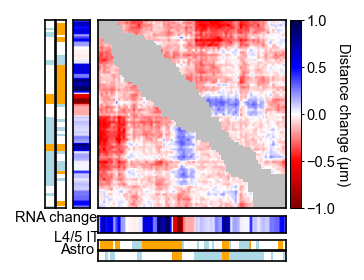

In [20]:
%matplotlib inline

chosen_chrom = '16'
sel_chrom = f'chr{chosen_chrom}'

rna_summary_df_chr = rna_summary_df[rna_summary_df['chr']==sel_chrom]


sel_group1 = 'L4/5 IT'
sel_group2 = 'Astro'


plt.rcParams['axes.grid'] = False
normalize_map = False
normalize_RNA = False
distMap_chr_group = {}
for _group in [sel_group1,sel_group2]:
    summary_dict = subclass_2_medianDict[_group]
    _cis_mat, chr_edges, chr_names = distance.assemble_ChrDistDict_2_Matrix(
            summary_dict, codebook_df, 
            sel_codebook=sel_codebook, 
            use_cis=True, sort_by_region=sort_by_region,
        )

    _chr_indices = chr_2_indices[chosen_chrom]
    cis_mat_chr = _cis_mat[:,_chr_indices]
    cis_mat_chr = cis_mat_chr[_chr_indices,:]
    if normalize_map:
        cis_mat_chr = cis_mat_chr/norm_factor_dict[_group][chosen_chrom]
    distMap_chr_group[_group]=cis_mat_chr

distMap_chr_group_dif = distMap_chr_group[sel_group2] - distMap_chr_group[sel_group1]
sel_chrom = f'chr{chosen_chrom}'
dist_mask_chr = chr_gene_dist_matrices[sel_chrom]

sel_mask = dist_mask_chr >10000000
distMap_chr_group_dif[~sel_mask]=np.nan
#sel_mask2 = dist_mask_chr <70000000
#distMap_chr_group_dif[~sel_mask2]=np.nan



from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax1 = plt.subplots(figsize=(_page_width/2.5,_page_width/2.5), dpi=150)
#####################################################################################################
# plot for distance change
dist_change_th = 1
vmin = -dist_change_th
vmax = dist_change_th

dist_cmap = cm.get_cmap('seismic_r').copy()
dist_cmap.set_bad(color=[0.5,0.5,0.5,0.5])

gfg = ax1.imshow(distMap_chr_group_dif, 
           cmap=dist_cmap,
           vmin=vmin,
           vmax=vmax
           #norm='log'
          )

ax1.tick_params('both', labelsize=_font_size-1, 
                        width=_ticklabel_width, length=0,
                        pad=1, labelleft=False, labelbottom=False)

divider = make_axes_locatable(ax1)

# colorbar ax
cax = divider.append_axes('right', size='6%', pad="2%")
cbar = plt.colorbar(gfg,cax=cax, ax=ax1, #ticks=[vmin, vmin/2, 0.0, vmax/2, vmax]
                   )
#cbar.ax.set_yticklabels([str(vmin), '', '0', '', str(vmax)])
cbar.ax.tick_params('both', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size-0.5,
                pad=1, labelleft=False) # remove bottom ticklabels for ax1
[i[1].set_linewidth(_ticklabel_width) for i in cbar.ax.spines.items()]
#cbar.set_ticks([vmin,vmax])
cbar.outline.set_linewidth(_ticklabel_width)
cbar.set_label('Distance change (\u03BCm)', 
               fontsize=_font_size-0.5, labelpad=7, rotation=270)
cbar.ax.minorticks_off()

#######################################################################################
# plot for RNA value change
activity_vals_group = {}
for _group_idx, _group in enumerate([sel_group1,sel_group2]):
    rna_summary_df_chr_group  = rna_summary_df_chr[rna_summary_df_chr['celltype']==_group]
    activity_vals = np.array(rna_summary_df_chr_group['rna'].tolist())
    # normalize to 0-1
    if normalize_RNA:
        activity_vals = np.array([(i-min(activity_vals))/(max(activity_vals)-min(activity_vals)) for i in activity_vals])
    activity_vals_group[_group] = activity_vals
    #print(_group, activity_vals)
activity_vals_group_diff = activity_vals_group[sel_group2] - activity_vals_group[sel_group1]
activity_vals_group_diff =  np.reshape(activity_vals_group_diff, (-1, 1)).transpose()
activity_vals_group_diff = np.repeat(activity_vals_group_diff,len(cis_mat_chr)/10, axis=0)


rna_change_th = 50
rna_vmin = -rna_change_th
rna_vmax = rna_change_th

rna_bot_ax = divider.append_axes('bottom', size='15%', pad="1%", 
                             sharex=ax1, xticks=[])
gfg2 = rna_bot_ax.imshow(activity_vals_group_diff, cmap='seismic' , vmin=rna_vmin,vmax=rna_vmax,
                 )

rna_bot_ax.tick_params('x', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=_ticklabel_size,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
rna_bot_ax.tick_params('y', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
rna_bot_ax.set_ylabel(f'RNA change', fontsize=_font_size-0.5, rotation = 0, labelpad=20,loc='center')    

rna_left_ax = divider.append_axes('left', size='15%', pad="1%", 
                             sharey=ax1, xticks=[])
rna_left_ax.imshow(activity_vals_group_diff.transpose(), cmap='seismic' , vmin=rna_vmin,vmax=rna_vmax,
                  )

rna_left_ax.tick_params('y', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False)
rna_left_ax.tick_params('x', labelsize=_font_size-0.5, 
                width=_ticklabel_width, length=0,
                pad=1, labelleft=False, labelbottom=False)

#####################################################################################################
# plot for transcriptional activity type
rna_summary_df_chr = rna_summary_df[rna_summary_df['chr']==sel_chrom]

for _group_idx, _group in enumerate([sel_group1,sel_group2]):
    rna_summary_df_chr_group  = rna_summary_df_chr[rna_summary_df_chr['celltype']==_group]
    activity_types = np.array(rna_summary_df_chr_group['transcription_activity'].tolist())

    bot_ax = divider.append_axes('bottom', size='5%', pad="1%", 
                                 sharex=ax1, xticks=[])
    bot_ax.bar(np.where(activity_types=='high')[0], 1, color='orange', width=1, bottom=0)
    bot_ax.bar(np.where(activity_types=='low')[0], 1,color='lightblue', width=1, bottom=0)

    bot_ax.tick_params('x', labelsize=_font_size-0.5, 
                    width=_ticklabel_width, length=_ticklabel_size,
                    pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
    bot_ax.tick_params('y', labelsize=_font_size-0.5, 
                    width=_ticklabel_width, length=0,
                    pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
    bot_ax.set_ylabel(f'{_group}', fontsize=_font_size-0.5, rotation = 0, labelpad=10,loc='center')


    # create left ax
    left_ax = divider.append_axes('left', size='5%', pad="1%", 
                                 sharey=ax1, xticks=[])
    left_ax.barh(np.where(activity_types=='high')[0], height=1, 
               color='orange',width=1, left=0)
    left_ax.barh(np.where(activity_types=='low')[0], height=1,
               color='lightblue',width=1, left=0)

    left_ax.tick_params('y', labelsize=_font_size-1, 
                    width=_ticklabel_width, length=0,
                    pad=1, labelleft=False, labelbottom=False)
    left_ax.tick_params('x', labelsize=_font_size-1, 
                    width=_ticklabel_width, length=0,
                    pad=1, labelleft=False, labelbottom=False)
    #left_ax.set_xlabel(f'{_group}', fontsize=_font_size-2, rotation = 90, labelpad=10)
    
#ax.grid(False)
sel_group1=sel_group1.replace('/','_').replace(' ','_')
sel_group2=sel_group2.replace('/','_').replace(' ','_')
plt.savefig(os.path.join(output_figure_folder, f"distMap_change_from_{sel_group1}_to_{sel_group2}_chr{chosen_chrom}.pdf"),
                transparent=True, bbox_inches='tight', dpi=300)
plt.show()

In [21]:
distMap_chr_group_dif.shape

(76, 76)

# Identify regions with local changes

In [22]:
region_wd = 10
distMap_diff_1D = np.nanmean(distMap_chr_group_dif, axis=0)

distMap_inds_1D = np.arange(len(distMap_diff_1D))
distMap_inds_1D_ascend = distMap_inds_1D[np.argsort(distMap_diff_1D)][::-1]
distMap_inds_1D_ascend[:]


array([33, 34, 55, 69, 32, 61, 31, 70, 38, 62, 54, 35, 73, 50, 71, 68, 30,
       63, 37, 65, 56, 72, 29, 53, 67, 66, 75, 52, 49, 60, 36, 74, 12, 64,
       26, 22, 51, 48, 19, 47, 18, 44, 45, 20, 17, 16, 21, 13, 46, 28, 11,
       40, 25, 59,  7, 43, 27, 15, 58, 23, 24, 39,  9,  6, 14, 42, 10, 41,
       57,  5,  4,  8,  3,  2,  1,  0])

In [23]:
loc = sorted([l for l in distMap_inds_1D_ascend[:region_wd] if l < 35])
loc

[31, 32, 33, 34]

In [24]:
local_th = 0.2
loc_out = np.array(sorted(np.where(distMap_chr_group_dif[loc[0]:loc[-1]+1,:]>local_th)[1]))
loc_out 

array([ 7, 43, 43, 44, 44, 44, 45, 45, 45, 46, 46, 47, 47, 47, 48, 48, 49,
       49, 49, 49, 50, 50, 51, 52, 52, 52, 53, 54, 55, 55, 55, 56, 60, 60,
       61, 62, 62, 63, 63], dtype=int64)

In [25]:
loc_out = np.arange(43,64)

## load raw chr zxy

In [26]:
postanalysis_folder = r'\\10.245.74.158\Chromatin_NAS_8\Analyzed_data\MouseBrain_PostAnalysis_20230201\MOp_WT_postanalysis\postanalysis_vCW2_sorted'
subclass_2_chr2Zxys_filename = os.path.join(postanalysis_folder, 'subclass_2_chr2Zxys.pkl')
subclass_2_chr2ZxysList = pickle.load(open(subclass_2_chr2Zxys_filename, 'rb'))

In [27]:
subclass_2_chr2ZxysList.keys()

dict_keys(['Oligo', 'L5 IT', 'Micro', 'Peri', 'Endo', 'Astro', 'OPC', 'L6 CT', 'L5 ET', 'L5/6 NP', 'Pvalb', 'L6 IT', 'Lamp5', 'L6b', 'Sst', 'SMC', 'L4/5 IT', 'L2/3 IT', 'Vip', 'Sncg', 'VLMC'])

In [28]:
group1 = 'Astro'
group2 = 'L4/5 IT'

In [29]:
from scipy.spatial.distance import pdist, squareform, cdist

_group_dist_df_list = []
raw_distance_by_group = {}

chr_reg_th = 45

shift = 5
for _group in [group1,group2]:
    raw_distance_by_group[_group] = {'loop_out':[], 'loop_upstream':[], 'loop_downstream':[]}
    _chr2ZxysList = subclass_2_chr2ZxysList[_group]
    # loo cells
    for _chr2Zxys in  _chr2ZxysList:
        
        if chosen_chrom in _chr2Zxys.keys():
            # each haploid
            for _chr2Zxys_ichr in _chr2Zxys[chosen_chrom]:
                # filter out short-range and low quality chr
                if np.sum(~np.isnan(_chr2Zxys_ichr), axis=0)[0] > chr_reg_th:
                    _chr_matrix = squareform(pdist(_chr2Zxys_ichr)) 
                    _chr_matrix[~sel_mask]=np.nan
                    dist_loc_out = np.nanmedian(_chr_matrix[loc[0]:loc[-1]+1,  loc_out[0]:loc_out[-1]+1])
                    dist_loc_left = np.nanmedian(_chr_matrix[loc[0]-shift:loc[-1]+1-shift,  loc_out[0]:loc_out[-1]+1])
                    dist_loc_right = np.nanmedian(_chr_matrix[loc[0]+shift:loc[-1]+1+shift,  loc_out[0]:loc_out[-1]+1])

                    raw_distance_by_group[_group]['loop_out'].append(dist_loc_out)
                    raw_distance_by_group[_group]['loop_upstream'].append(dist_loc_left)
                    raw_distance_by_group[_group]['loop_downstream'].append(dist_loc_right)
                
    _group_dist_df = pd.DataFrame(raw_distance_by_group[_group])
    _group_dist_df['celltype'] = _group
    _group_dist_df_list.append(_group_dist_df)
    
    
merged_group_dist_df = pd.concat(_group_dist_df_list)

merged_group_dist_df['out_2_downstream'] = merged_group_dist_df['loop_out'] - merged_group_dist_df['loop_downstream']
merged_group_dist_df['out_2_upstream'] = merged_group_dist_df['loop_out'] - merged_group_dist_df['loop_upstream']

merged_group_dist_df

C:\Users\shiwei\Anaconda3\envs\shiwei_chromatin\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,
C:\Users\shiwei\Anaconda3\envs\shiwei_chromatin\lib\site-packages\numpy\lib\nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  r, k = function_base._ureduce(a, func=_nanmedian, axis=axis, out=out,


,loop_out,loop_upstream,loop_downstream,celltype,out_2_downstream,out_2_upstream
0,1.468388,1.109815,0.941169,Astro,0.527219,0.358573
1,1.328141,1.391801,1.457542,Astro,-0.129401,-0.063660
2,1.610235,1.226261,1.504364,Astro,0.105871,0.383974
3,1.563036,1.734040,2.136468,Astro,-0.573432,-0.171004
4,1.383249,1.312675,NaN,Astro,NaN,0.070574
...,...,...,...,...,...,...
381,NaN,2.768306,2.301879,L4/5 IT,NaN,NaN
382,2.272126,1.631846,2.304885,L4/5 IT,-0.032759,0.640280
383,2.763315,1.520176,2.424348,L4/5 IT,0.338967,1.243139
384,3.188187,1.291181,2.022907,L4/5 IT,1.165281,1.897006


In [30]:
#output_figure_folder

In [34]:
merged_group_dist_df

,loop_out,loop_upstream,loop_downstream,celltype,out_2_downstream,out_2_upstream
0,1.468388,1.109815,0.941169,Astro,0.527219,0.358573
1,1.328141,1.391801,1.457542,Astro,-0.129401,-0.063660
2,1.610235,1.226261,1.504364,Astro,0.105871,0.383974
3,1.563036,1.734040,2.136468,Astro,-0.573432,-0.171004
4,1.383249,1.312675,NaN,Astro,NaN,0.070574
...,...,...,...,...,...,...
381,NaN,2.768306,2.301879,L4/5 IT,NaN,NaN
382,2.272126,1.631846,2.304885,L4/5 IT,-0.032759,0.640280
383,2.763315,1.520176,2.424348,L4/5 IT,0.338967,1.243139
384,3.188187,1.291181,2.022907,L4/5 IT,1.165281,1.897006


meta NOT subset; don't know how to subset; dropped


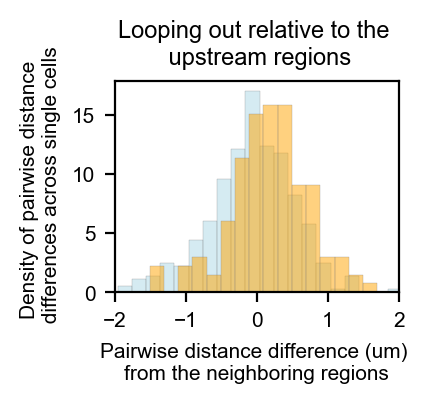

meta NOT subset; don't know how to subset; dropped


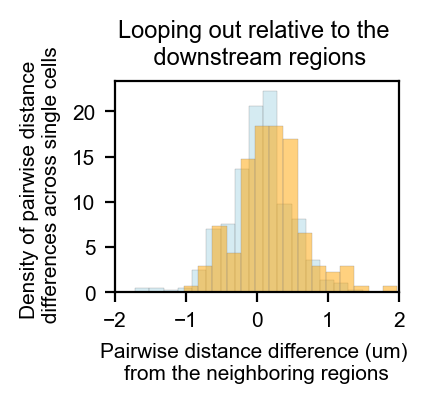

In [46]:
import seaborn as sns

for _dir in  ['upstream', 'downstream']:

    fig, ax = plt.subplots(figsize=(_page_width/3,_page_width/4),dpi=200)
    _color_dict ={'L4/5 IT':'lightblue', 'Astro':'orange'}
    for _celltype in ['L4/5 IT','Astro']:
        _subset = merged_group_dist_df[merged_group_dist_df['celltype']==_celltype]
        sns.histplot(data=_subset, x=f'out_2_{_dir}',
                             ax=ax,
                             binwidth=.2,
                             #bins=30, 
                              alpha=0.5, 
                              linewidth=0.1, 
                             edgecolor='gray',
                             stat='percent', color=_color_dict[_celltype])


    plt.xlim([-2, 2])
    plt.xlabel('Pairwise distance difference (um) \nfrom the neighboring regions', fontsize = _font_size)
    plt.ylabel('Density of pairwise distance \n differences across single cells', fontsize = _font_size)
    plt.title(f'Looping out relative to the \n {_dir} regions', fontsize = _font_size+1)
    plt.tick_params(axis='y', labelsize=_font_size) 
    plt.tick_params(axis='x', rotation=0, labelsize=_font_size) 

    
    plt.savefig(os.path.join(output_figure_folder, f'Chr{chosen_chrom}_looping_{_dir}_single_cells_percent.pdf'), 
            transparent=True, dpi=300, bbox_inches='tight')
    
    plt.show()

# Plot single allele trace

In [32]:
from ImageAnalysis3 import _distance_zxy
from ImageAnalysis3.figure_tools.color import transparent_gradient
from ImageAnalysis3.figure_tools import _dpi,_single_col_width,_double_col_width,_single_row_height,_ref_bar_length, _ticklabel_size,_ticklabel_width,_font_size
#_color_dict={
    #'A':[1.,0.,0.],
    #'B':[0.,0.,1.],
#}
# 3d plotting
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D
from skimage.measure import marching_cubes # 3d cloud calculation

In [33]:
from ImageAnalysis3.figure_tools.plot_decode import Centering_Chr2ZxysListDict, summarize_chr2Zxys
from ImageAnalysis3.structure_tools.distance import sort_chr
# use new version of sort chr to assign chrX as chr20 so the chr_colorbar would look correct below
help(loci_1d_features.sort_mouse_chr)

Help on function sort_mouse_chr in module loci_1d_features:

sort_mouse_chr(_chr)
    # Use for sorting chromosome by number (from PZ)



In [34]:
genome_cmap = cm.Spectral.copy()

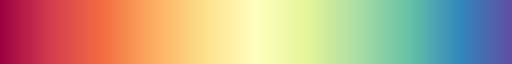

In [45]:
genome_cmap

## only chosen allele

In [38]:
chr_reg_th = 50

sel_subclass = 'Astro'
sel_cell_indices = []
for _cell_index, _chr2Zxys in enumerate(subclass_2_chr2ZxysList[sel_subclass]):
    if chosen_chrom in _chr2Zxys.keys():
        for _chr2Zxys_ichr in _chr2Zxys[chosen_chrom]:
                # filter out low quality chr
                if np.sum(~np.isnan(_chr2Zxys_ichr), axis=0)[0] > chr_reg_th:
                    sel_cell_indices.append(_cell_index)
        
print(len(sel_cell_indices))

20


In [119]:
def Centering_Chr2ZxysListDict_v2(chr_2_zxys_list, center_chr = '0'):
    # center
    _all_zxys = []
    for _zxys_list in chr_2_zxys_list.values():
        _all_zxys.extend(list(_zxys_list))
    if center_chr in chr_2_zxys_list.keys():
        _center = np.nanmean(np.concatenate(chr_2_zxys_list[center_chr]), axis=0)
    else:
        _center = np.nanmean(np.concatenate(_all_zxys), axis=0)
    _centered_dict = {}
    for _chr, _zxys_list in chr_2_zxys_list.items():
        _centered_dict[_chr] = _zxys_list - _center[np.newaxis,:]
        
    return _centered_dict

1863


<IPython.core.display.Javascript object>


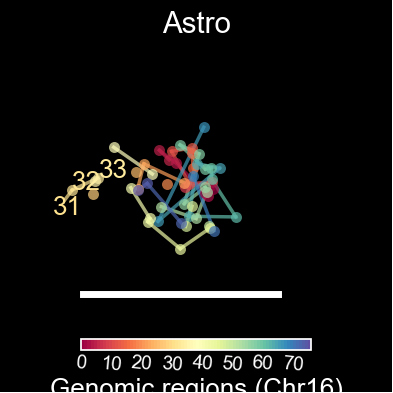

0.0 0.5235987755982988


meta NOT subset; don't know how to subset; dropped


In [124]:
%matplotlib notebook
#%matplotlib notebook
# select one cell from the candidate indices
_idx_to_plot = 6
_sel_cell_ind = sel_cell_indices[_idx_to_plot]
print(_sel_cell_ind)
_dict = subclass_2_chr2ZxysList[sel_subclass][_sel_cell_ind]



from matplotlib.colors import BoundaryNorm
from matplotlib import animation
plot_animation = False
hide_axes = True
add_refBar = True
refBar_len = 5 # in um
angle = 5

#_centered_dict = Centering_Chr2ZxysListDict(_dict)
_centered_dict = Centering_Chr2ZxysListDict_v2(_dict,center_chr = chosen_chrom)
len_chr = len(subclass_2_chr2ZxysList[sel_subclass][_sel_cell_ind][chosen_chrom][0])
_chr_2_color = {_id:genome_cmap(_id/len_chr) for _id in np.arange(0,len_chr)}
_chr_2_color

plot_radius = 2

marker_size = 10
marker_alpha = 0.7

depthshade=False
fig = plt.figure(figsize=(_page_width/3.5, _page_width/3.5), dpi=200)

ax3d = fig.add_subplot(111, projection='3d', azim=0, elev=30)
#ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.9)
# turn off axes if needed
if hide_axes:
    ax3d.set_axis_off()
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# scatter plot
for _chr in [chosen_chrom]:
    _zxys_list = _centered_dict[_chr]
    for _zxys in _zxys_list:
        #print(_chr)
        _valid_inds = (np.isnan(_zxys).sum(1) == 0)
        
        if np.sum(_valid_inds) > chr_reg_th:
            for _ind_chr, _valid_ind in enumerate(_valid_inds):
                _sc = ax3d.scatter(_zxys[_ind_chr,1], _zxys[_ind_chr,2], _zxys[_ind_chr,0],
                               color=_chr_2_color[_ind_chr], 
                               s=marker_size, depthshade=depthshade, 
                               alpha=marker_alpha,
                               #edgecolors=_edge_colors, 
                               linewidth=0, label=f"{_chr}")

                if _ind_chr < len_chr-1:
                    _ln = ax3d.plot([_zxys[_ind_chr,1],_zxys[_ind_chr+1,1]], 
                                [_zxys[_ind_chr,2],_zxys[_ind_chr+1,2]], 
                                [_zxys[_ind_chr,0],_zxys[_ind_chr+1,0]],
                            color=_chr_2_color[_ind_chr], linewidth=1, alpha=marker_alpha)

                if _ind_chr in loc and _valid_ind:
                    ax3d.text(_zxys[_ind_chr,1], _zxys[_ind_chr,2], _zxys[_ind_chr,0], 
                            '%s' % (str(_ind_chr)), size=_font_size, zorder=1,  
                                                         color=_chr_2_color[_ind_chr]) 

            #_ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                            #color='white', linewidth=1, alpha=marker_alpha)
            
            
ax3d.tick_params('both', labelsize=_font_size, 
                    width=0, length=0,
                    pad=0, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(0.5) for i in ax3d.spines.items()]

# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size, labelpad=0)
# title
ax3d.set_title(f"{sel_subclass}" ,fontsize=_font_size+1, pad=0)
# colorbar
bounds = list(range(0, len_chr))
bounds.append(np.max(bounds)+1)
bounds = np.sort(bounds)
norm = BoundaryNorm(bounds, genome_cmap.N)
cbar_shrink = 0.65
m = cm.ScalarMappable(cmap=genome_cmap, norm=norm)
cbar = plt.colorbar(m, ax=ax3d, orientation='horizontal', pad=0.1, 
                    #ticks=bounds[:-1]+0.5,
                    ticks = [i for i in np.arange(len_chr) if i%10 ==0],
                    boundaries=bounds,
                    shrink=cbar_shrink)
cbar.set_label(f'Genomic regions (Chr{chosen_chrom})', fontsize=_font_size, labelpad=1,)
cbar.ax.set_xticklabels([i for i in np.arange(len_chr) if i%10 ==0], fontsize=_font_size)

cbar.ax.tick_params('both', which='both',labelsize=_font_size-2, 
                    width=0.0, length=0.0,rotation =-5,
                    pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
# vertical alignment of xtick labels
va = [-0.01 if i%2 else 0 for i in range(len(cbar.ax.get_xticklabels()))]
for t, y in zip(cbar.ax.get_xticklabels(), va):
    t.set_y(y)

[i[1].set_linewidth(0.5) for i in cbar.ax.spines.items()]



# save
fig_basename = f"Decode3D_type_{sel_subclass.replace(' ', '_').replace(r'/', '-')}_cell_{_sel_cell_ind}_{chosen_chrom}"
# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(output_figure_folder, fig_basename+".gif"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # add ref
    if add_refBar:
        # convert to degree, which matches numpy cos and sin
        _azim = (ax3d.azim%360) / 180 * np.pi 
        _elev = (ax3d.elev%360) / 180 * np.pi
        print(_azim, _elev)
        # start coordinate for colorbar
        _bar_starts = np.array([-2.5, # z, draw to the bottom
                                -np.sin(_azim), # x, y, extension goes through 0,0
                                np.cos(_azim), 
                                ]) * plot_radius
        # ongoing vector for colorbar:
        _bar_vector = np.array([0,
                                np.sin(_azim),
                                -np.cos(_azim),
                                ]) * refBar_len
        # therefore, end of colorbar
        _bar_ends = _bar_starts + _bar_vector
        #print(_bar_starts, _bar_ends)
        _ref_line = ax3d.plot([_bar_starts[1], _bar_ends[1]],
                              [_bar_starts[2], _bar_ends[2]], 
                              [_bar_starts[0], _bar_ends[0]], 
                              color=tuple([1-_c for _c in ax3d.get_facecolor()[:3]]+[1]), 
                              linewidth=2)

    # save pdf and png
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".pdf"),
                transparent=False, bbox_inches='tight', pad_inches=.05, dpi=300)
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".png"),
                transparent=False, bbox_inches='tight', pad_inches=.05, dpi=300)
fig.show()

159


<IPython.core.display.Javascript object>


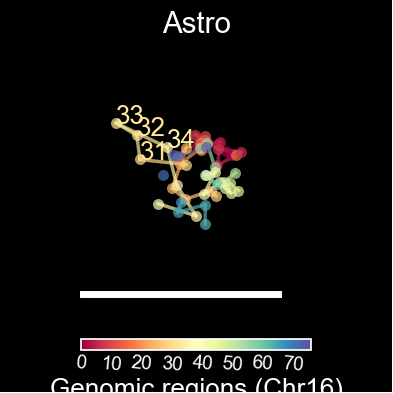

0.0 0.5235987755982988


meta NOT subset; don't know how to subset; dropped


In [125]:
%matplotlib notebook
#%matplotlib notebook
# select one cell from the candidate indices
_idx_to_plot = 0
_sel_cell_ind = sel_cell_indices[_idx_to_plot]
print(_sel_cell_ind)
_dict = subclass_2_chr2ZxysList[sel_subclass][_sel_cell_ind]



from matplotlib.colors import BoundaryNorm
from matplotlib import animation
plot_animation = False
hide_axes = True
add_refBar = True
refBar_len = 5 # in um
angle = 5

#_centered_dict = Centering_Chr2ZxysListDict(_dict)
_centered_dict = Centering_Chr2ZxysListDict_v2(_dict,center_chr = chosen_chrom)
len_chr = len(subclass_2_chr2ZxysList[sel_subclass][_sel_cell_ind][chosen_chrom][0])
_chr_2_color = {_id:genome_cmap(_id/len_chr) for _id in np.arange(0,len_chr)}
_chr_2_color

plot_radius = 2

marker_size = 10
marker_alpha = 0.7

depthshade=False
fig = plt.figure(figsize=(_page_width/3.5, _page_width/3.5), dpi=200)

ax3d = fig.add_subplot(111, projection='3d', azim=0, elev=30)
#ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.9)
# turn off axes if needed
if hide_axes:
    ax3d.set_axis_off()
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# scatter plot
for _chr in [chosen_chrom]:
    _zxys_list = _centered_dict[_chr]
    for _zxys in _zxys_list:
        #print(_chr)
        _valid_inds = (np.isnan(_zxys).sum(1) == 0)
        
        if np.sum(_valid_inds) > chr_reg_th:
            for _ind_chr, _valid_ind in enumerate(_valid_inds):
                _sc = ax3d.scatter(_zxys[_ind_chr,1], _zxys[_ind_chr,2], _zxys[_ind_chr,0],
                               color=_chr_2_color[_ind_chr], 
                               s=marker_size, depthshade=depthshade, 
                               alpha=marker_alpha,
                               #edgecolors=_edge_colors, 
                               linewidth=0, label=f"{_chr}")

                if _ind_chr < len_chr-1:
                    _ln = ax3d.plot([_zxys[_ind_chr,1],_zxys[_ind_chr+1,1]], 
                                [_zxys[_ind_chr,2],_zxys[_ind_chr+1,2]], 
                                [_zxys[_ind_chr,0],_zxys[_ind_chr+1,0]],
                            color=_chr_2_color[_ind_chr], linewidth=1, alpha=marker_alpha)

                if _ind_chr in loc and _valid_ind:
                    ax3d.text(_zxys[_ind_chr,1], _zxys[_ind_chr,2], _zxys[_ind_chr,0], 
                            '%s' % (str(_ind_chr)), size=_font_size, zorder=1,  
                                                         color=_chr_2_color[_ind_chr]) 

            #_ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                            #color='white', linewidth=1, alpha=marker_alpha)
            
            
ax3d.tick_params('both', labelsize=_font_size, 
                    width=0, length=0,
                    pad=0, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(0.5) for i in ax3d.spines.items()]

# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size, labelpad=0)
# title
ax3d.set_title(f"{sel_subclass}" ,fontsize=_font_size+1, pad=0)
# colorbar
bounds = list(range(0, len_chr))
bounds.append(np.max(bounds)+1)
bounds = np.sort(bounds)
norm = BoundaryNorm(bounds, genome_cmap.N)
cbar_shrink = 0.65
m = cm.ScalarMappable(cmap=genome_cmap, norm=norm)
cbar = plt.colorbar(m, ax=ax3d, orientation='horizontal', pad=0.1, 
                    #ticks=bounds[:-1]+0.5,
                    ticks = [i for i in np.arange(len_chr) if i%10 ==0],
                    boundaries=bounds,
                    shrink=cbar_shrink)
cbar.set_label(f'Genomic regions (Chr{chosen_chrom})', fontsize=_font_size, labelpad=1,)
cbar.ax.set_xticklabels([i for i in np.arange(len_chr) if i%10 ==0], fontsize=_font_size)

cbar.ax.tick_params('both', which='both',labelsize=_font_size-2, 
                    width=0.0, length=0.0,rotation =-5,
                    pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
# vertical alignment of xtick labels
va = [-0.01 if i%2 else 0 for i in range(len(cbar.ax.get_xticklabels()))]
for t, y in zip(cbar.ax.get_xticklabels(), va):
    t.set_y(y)

[i[1].set_linewidth(0.5) for i in cbar.ax.spines.items()]



# save
fig_basename = f"Decode3D_type_{sel_subclass.replace(' ', '_').replace(r'/', '-')}_cell_{_sel_cell_ind}_{chosen_chrom}"
# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(output_figure_folder, fig_basename+".gif"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # add ref
    if add_refBar:
        # convert to degree, which matches numpy cos and sin
        _azim = (ax3d.azim%360) / 180 * np.pi 
        _elev = (ax3d.elev%360) / 180 * np.pi
        print(_azim, _elev)
        # start coordinate for colorbar
        _bar_starts = np.array([-2.5, # z, draw to the bottom
                                -np.sin(_azim), # x, y, extension goes through 0,0
                                np.cos(_azim), 
                                ]) * plot_radius
        # ongoing vector for colorbar:
        _bar_vector = np.array([0,
                                np.sin(_azim),
                                -np.cos(_azim),
                                ]) * refBar_len
        # therefore, end of colorbar
        _bar_ends = _bar_starts + _bar_vector
        #print(_bar_starts, _bar_ends)
        _ref_line = ax3d.plot([_bar_starts[1], _bar_ends[1]],
                              [_bar_starts[2], _bar_ends[2]], 
                              [_bar_starts[0], _bar_ends[0]], 
                              color=tuple([1-_c for _c in ax3d.get_facecolor()[:3]]+[1]), 
                              linewidth=2)

    # save pdf and png
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".pdf"),
                transparent=False, bbox_inches='tight', pad_inches=.05, dpi=300)
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".png"),
                transparent=False, bbox_inches='tight', pad_inches=.05, dpi=300)
fig.show()

In [254]:
chr_reg_th = 45
loc_th = 3
sel_subclass = 'Astro'
sel_cell_indices = []
for _cell_index, _chr2Zxys in enumerate(subclass_2_chr2ZxysList[sel_subclass]):
    if chosen_chrom in _chr2Zxys.keys():
        for _chr2Zxys_ichr in _chr2Zxys[chosen_chrom]:
                # filter out low quality chr
                if (np.sum(~np.isnan(_chr2Zxys_ichr), axis=0)[0] > chr_reg_th and 
                    np.sum(~np.isnan(_chr2Zxys_ichr[loc]), axis=0)[0] >= 3 ):
                    sel_cell_indices.append(_cell_index)
        
print(len(sel_cell_indices))
len(sel_cell_indices)

74


74

In [255]:
#sel_cell_indices

2367


<IPython.core.display.Javascript object>


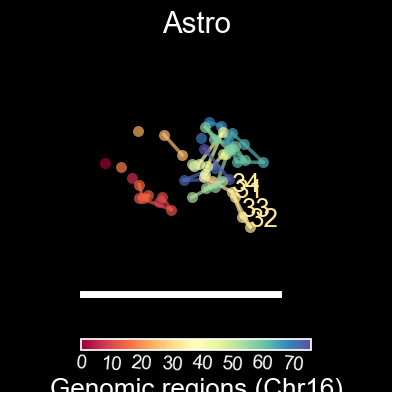

0.0 0.5235987755982988


meta NOT subset; don't know how to subset; dropped


In [265]:
%matplotlib notebook
#%matplotlib notebook
# select one cell from the candidate indices
_idx_to_plot = 38

_sel_cell_ind = sel_cell_indices[_idx_to_plot]
print(_sel_cell_ind)
_dict = subclass_2_chr2ZxysList[sel_subclass][_sel_cell_ind]



from matplotlib.colors import BoundaryNorm
from matplotlib import animation
plot_animation = False
hide_axes = True
add_refBar = True
refBar_len = 5 # in um
angle = 90

#_centered_dict = Centering_Chr2ZxysListDict(_dict)
_centered_dict = Centering_Chr2ZxysListDict_v2(_dict,center_chr = chosen_chrom)
len_chr = len(subclass_2_chr2ZxysList[sel_subclass][_sel_cell_ind][chosen_chrom][0])
_chr_2_color = {_id:genome_cmap(_id/len_chr) for _id in np.arange(0,len_chr)}
_chr_2_color

plot_radius = 2

marker_size = 10
marker_alpha = 0.7

depthshade=False
fig = plt.figure(figsize=(_page_width/3.5, _page_width/3.5), dpi=200)

ax3d = fig.add_subplot(111, projection='3d', azim=0, elev=30)
#ax3d.set_facecolor(background_color)
fig.subplots_adjust(left=0.05, right=0.95, bottom=0, top=0.9)
# turn off axes if needed
if hide_axes:
    ax3d.set_axis_off()
# turn off grid if needed
ax3d.grid(False)
ax3d.xaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.yaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
ax3d.zaxis.set_pane_color((0.0, 0.0, 0.0, 0.0))
# scatter plot
for _chr in [chosen_chrom]:
    _zxys_list = _centered_dict[_chr]
    for _zxys in _zxys_list:
        #print(_chr)
        _valid_inds = (np.isnan(_zxys).sum(1) == 0)
        
        if np.sum(_valid_inds) > chr_reg_th:
            for _ind_chr, _valid_ind in enumerate(_valid_inds):
                _sc = ax3d.scatter(_zxys[_ind_chr,1], _zxys[_ind_chr,2], _zxys[_ind_chr,0],
                               color=_chr_2_color[_ind_chr], 
                               s=marker_size, depthshade=depthshade, 
                               alpha=marker_alpha,
                               #edgecolors=_edge_colors, 
                               linewidth=0, label=f"{_chr}")

                if _ind_chr < len_chr-1 and _valid_ind:
                    _ln = ax3d.plot([_zxys[_ind_chr,1],_zxys[_ind_chr+1,1]], 
                                [_zxys[_ind_chr,2],_zxys[_ind_chr+1,2]], 
                                [_zxys[_ind_chr,0],_zxys[_ind_chr+1,0]],
                            color=_chr_2_color[_ind_chr], linewidth=1, alpha=marker_alpha)
                    

                if _ind_chr in loc and _valid_ind:
                    ax3d.text(_zxys[_ind_chr,1], _zxys[_ind_chr,2], _zxys[_ind_chr,0], 
                            '%s' % (str(_ind_chr)), size=_font_size, zorder=1,  
                                                         color=_chr_2_color[_ind_chr]) 

            #_ln = ax3d.plot(_zxys[_valid_inds,1], _zxys[_valid_inds,2], _zxys[_valid_inds,0],
                            #color='white', linewidth=1, alpha=marker_alpha)
            
            
ax3d.tick_params('both', labelsize=_font_size, 
                    width=0, length=0,
                    pad=0, labelleft=True, labelbottom=True) # remove bottom ticklabels for ax1
[i[1].set_linewidth(0.5) for i in ax3d.spines.items()]

# axes limits
ax3d.axes.set_xlim3d(left=-plot_radius, right=plot_radius) 
ax3d.axes.set_ylim3d(bottom=-plot_radius, top=plot_radius) 
ax3d.axes.set_zlim3d(bottom=-plot_radius, top=plot_radius) 
# axes ticks
ax3d.set_xticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_yticks(np.arange(-plot_radius,plot_radius+1, 2))
ax3d.set_zticks(np.arange(-plot_radius,plot_radius+1, 2))
# axes labels
ax3d.set_xlabel(f"X (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_ylabel(f"Y (\u03BCm)", fontsize=_font_size, labelpad=0)
ax3d.set_zlabel(f"Z (\u03BCm)", fontsize=_font_size, labelpad=0)
# title
ax3d.set_title(f"{sel_subclass}" ,fontsize=_font_size+1, pad=0)
# colorbar
bounds = list(range(0, len_chr))
bounds.append(np.max(bounds)+1)
bounds = np.sort(bounds)
norm = BoundaryNorm(bounds, genome_cmap.N)
cbar_shrink = 0.65
m = cm.ScalarMappable(cmap=genome_cmap, norm=norm)
cbar = plt.colorbar(m, ax=ax3d, orientation='horizontal', pad=0.1, 
                    #ticks=bounds[:-1]+0.5,
                    ticks = [i for i in np.arange(len_chr) if i%10 ==0],
                    boundaries=bounds,
                    shrink=cbar_shrink)
cbar.set_label(f'Genomic regions (Chr{chosen_chrom})', fontsize=_font_size, labelpad=1,)
cbar.ax.set_xticklabels([i for i in np.arange(len_chr) if i%10 ==0], fontsize=_font_size)

cbar.ax.tick_params('both', which='both',labelsize=_font_size-2, 
                    width=0.0, length=0.0,rotation =-5,
                    pad=1, labelleft=False, labelbottom=True) # remove bottom ticklabels for ax1
# vertical alignment of xtick labels
va = [-0.01 if i%2 else 0 for i in range(len(cbar.ax.get_xticklabels()))]
for t, y in zip(cbar.ax.get_xticklabels(), va):
    t.set_y(y)

[i[1].set_linewidth(0.5) for i in cbar.ax.spines.items()]



# save
fig_basename = f"Decode3D_type_{sel_subclass.replace(' ', '_').replace(r'/', '-')}_cell_{_sel_cell_ind}_{chosen_chrom}"
# animation
if plot_animation:
    def rotate3D(angle):
         ax3d.view_init(azim=angle)
    ani = animation.FuncAnimation(fig, rotate3D, frames=np.arange(0, 360*2, angle), interval=50)
    ani.save(os.path.join(output_figure_folder, fig_basename+".gif"), 
             writer=animation.PillowWriter(fps=30), )
else:
    # add ref
    if add_refBar:
        # convert to degree, which matches numpy cos and sin
        _azim = (ax3d.azim%360) / 180 * np.pi 
        _elev = (ax3d.elev%360) / 180 * np.pi
        print(_azim, _elev)
        # start coordinate for colorbar
        _bar_starts = np.array([-2.5, # z, draw to the bottom
                                -np.sin(_azim), # x, y, extension goes through 0,0
                                np.cos(_azim), 
                                ]) * plot_radius
        # ongoing vector for colorbar:
        _bar_vector = np.array([0,
                                np.sin(_azim),
                                -np.cos(_azim),
                                ]) * refBar_len
        # therefore, end of colorbar
        _bar_ends = _bar_starts + _bar_vector
        #print(_bar_starts, _bar_ends)
        _ref_line = ax3d.plot([_bar_starts[1], _bar_ends[1]],
                              [_bar_starts[2], _bar_ends[2]], 
                              [_bar_starts[0], _bar_ends[0]], 
                              color=tuple([1-_c for _c in ax3d.get_facecolor()[:3]]+[1]), 
                              linewidth=2)

    # save pdf and png
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".pdf"),
                transparent=False, bbox_inches='tight', pad_inches=.05, dpi=300)
    fig.savefig(os.path.join(output_figure_folder, fig_basename+".png"),
                transparent=False, bbox_inches='tight', pad_inches=.05, dpi=300)
fig.show()